In [1]:
dhs_name = 'segway_genomebiol_2019'
resfile = f'../dhs_enrichment/{dhs_name}/gtex_dhs_enrichment_all_tissues.txt'
outfile = f'../plots/dhs_enrichment_{dhs_name}.png'

tissue_file = "../tissue_table.txt"
json_file = "../external/gtex_metadata.json"
nsample_file = "../tissue_nsamples.txt"

In [6]:
import numpy as np
import collections
import json

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import utils
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

In [3]:
RESINFO_FIELDS = ['ntrans', 'enrich', 'pvalue']
class ResInfo(collections.namedtuple('_ResInfo', RESINFO_FIELDS)):
    __slots__ = ()

def read_results(filename):
    res = dict()
    with open(filename, 'r') as infile:
        next(infile)
        for line in infile:
            linesplit = line.strip().split()
            tissue = linesplit[0]
            ntrans = int(linesplit[1].strip())
            enrich = float(linesplit[3].strip())
            pvalue = float(linesplit[4].strip())
            res[tissue] = ResInfo(ntrans = ntrans, enrich = enrich, pvalue = pvalue)
    return res

In [4]:
res = read_results(resfile)

tshorts, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
for tshort, tfull in zip(tshorts, tfulls):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    
tissue_nsamples = dict()
with open(nsample_file, 'r') as instream:
    for line in instream:
        tshort = line.strip().split()[0].strip()
        tissue_nsamples[tshort] = int(line.strip().split()[1].strip())

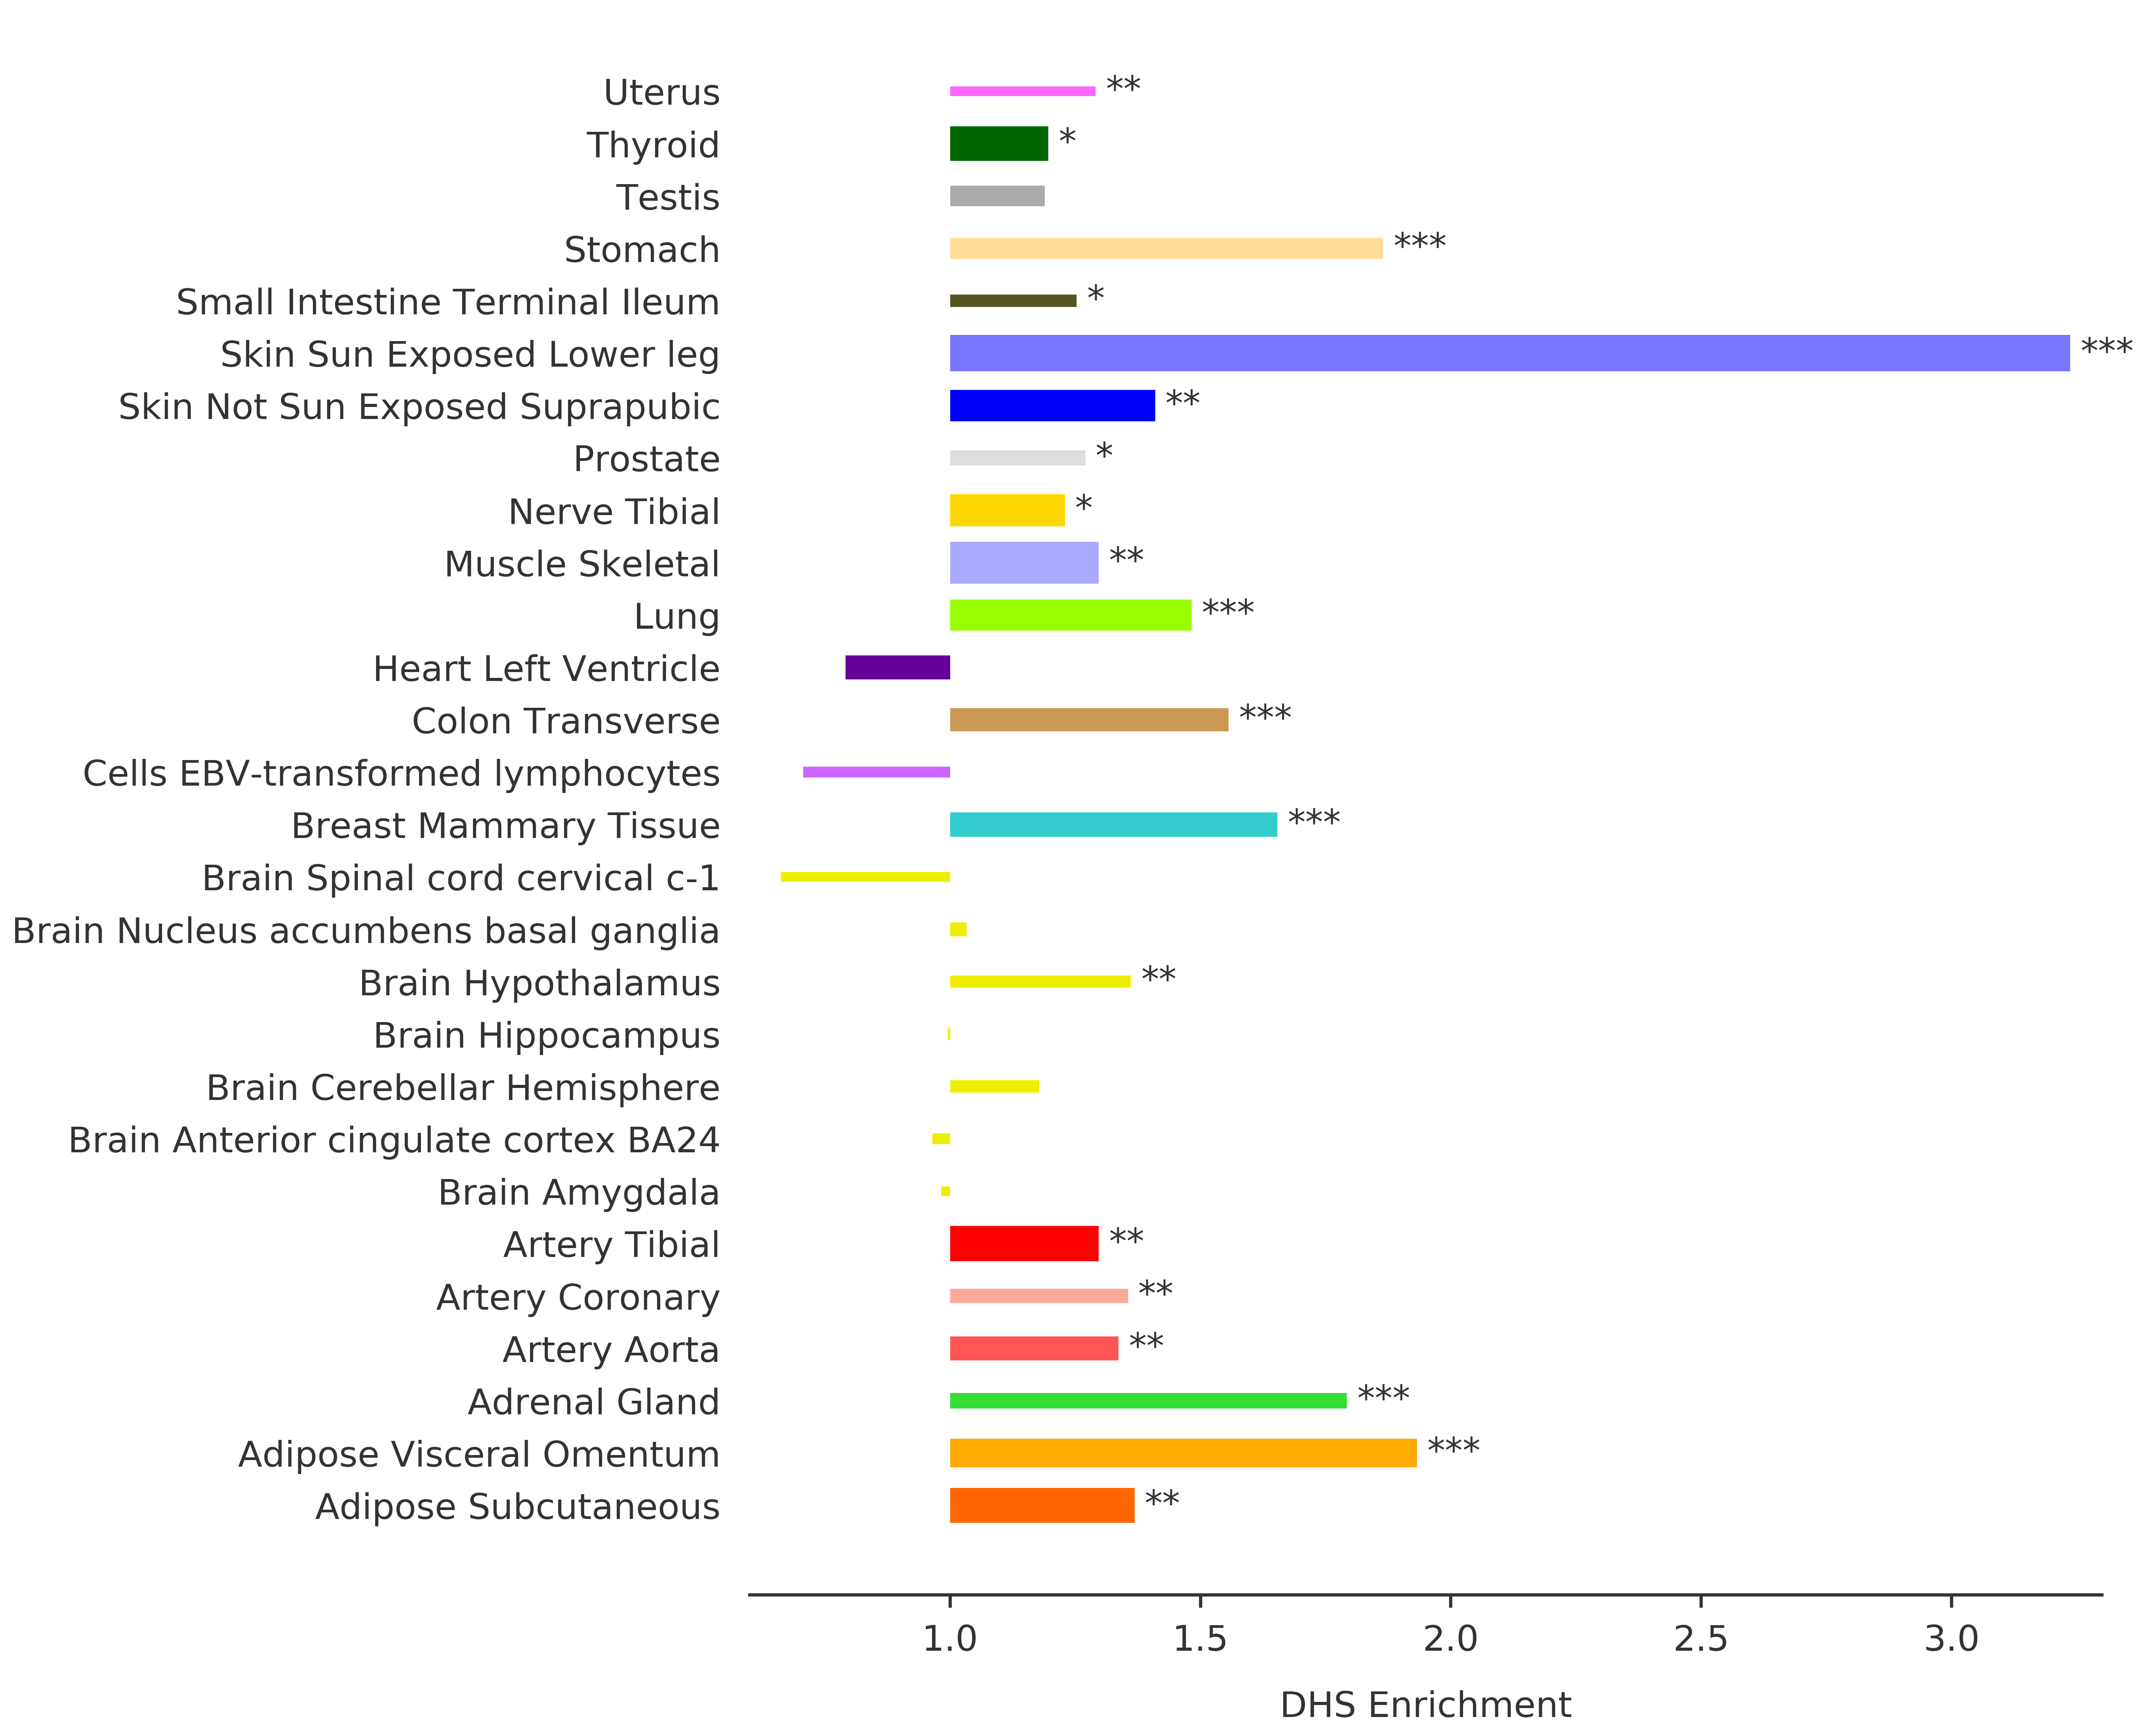

In [7]:
objects = list()
performance = list()
significance = list()
bar_colors = list()
bar_heights = list()

res_tissues = [key for key, val in res.items()]

nmax = max([tissue_nsamples[t] for t in res_tissues])
nmin = min([tissue_nsamples[t] for t in res_tissues])

for tshort in tshorts:
    if tshort in res_tissues:
        nteqtl = res[tshort].ntrans
        if nteqtl >= 200:         
            if nteqtl == 0:
                objects.append(tissue_names[tshort])
                performance.append(0)
                significance.append('')
            else:            
                tf_enrichment = res[tshort].enrich
                tf_enrichment_pval = res[tshort].pvalue

                objects.append(tissue_names[tshort])
                performance.append(tf_enrichment - 1.0)
                if tf_enrichment_pval <= 0.001:
                    significance.append('***')
                elif tf_enrichment_pval <= 0.01:
                    significance.append('**')
                elif tf_enrichment_pval <= 0.05:
                    significance.append('*')
                else:
                    significance.append('')
                    
            height = 0.05 + 0.75 * tissue_nsamples[tshort] / nmax 
            bar_colors.append(tissue_colors[tshort])
            bar_heights.append(height)

        

fig = plt.figure(figsize = (15, 18))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = bar_heights)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('DHS Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

plt.savefig(outfile, bbox_inches='tight')
plt.show()